In [4]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from helper import test_prediction, test_generation

In [5]:
# load all that we need

dataset = np.load('data/wiki.train.npy', allow_pickle=True)
devset = np.load('data/wiki.valid.npy', allow_pickle=True)
inference_pred = np.load('inference/prediction.npz')  # dev
inference_gen = np.load('inference/generation.npy')  # dev
inference_pred_test = np.load('inference/prediction_test.npz')  # test
inference_gen_test = np.load('inference/generation_test.npy')  # test
vocab = np.load('data/vocab.npy')

In [10]:
len(vocab)

33278

In [17]:

print(dataset.shape) #579 articles
print(dataset[0].shape) #no. of words in articles

(579,)
(3803,)


In [18]:

class LanguageModelDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.seq = 60

    def __iter__(self):

        def get_seq_len(seq_l):
            if np.random.random() < 0.95:
                seq_len = seq_l
            else:
                seq_len = seq_l/2
            seq_len = round(np.random.normal(seq_len, 5))
            return seq_len

        
        if self.shuffle == True:
            np.random.shuffle(self.dataset)

        
        new_shuffled_conncat_dataset = np.concatenate(self.dataset)
        print(new_shuffled_conncat_dataset)

        self.no_of_batches = (len(new_shuffled_conncat_dataset)-1)//self.batch_size 



        no_of_elements = self.batch_size *self.seq 

        
        
        for i in range(self.no_of_batches):
          no_of_elements = self.batch_size *self.seq 

          try:
            x = new_shuffled_conncat_dataset[i*no_of_elements:i*no_of_elements+no_of_elements]
            y = new_shuffled_conncat_dataset[(i*no_of_elements)+1:i*no_of_elements+no_of_elements+1]# X-> 2dim
            
            x = np.array(x).reshape(self.batch_size,self.seq)
            y = np.array(y).reshape(self.batch_size,self.seq)

            yield (torch.LongTensor(x),torch.LongTensor(y))
          except:
            pass
    

In [25]:
DL= LanguageModelDataLoader(dataset=dataset, batch_size=64, shuffle=True)
for data in DL:
    x,y = data
    print('X: ')
    print(x.shape)
    print(x[0,:])
    print([vocab[i] for i in x[0,:]])
    print('Y: ')
    print(x.shape)
    print(y[0,:])
    print([vocab[i] for i in y[0,:]])
    break

Exception ignored in: <generator object LanguageModelDataLoader.__iter__ at 0x7efb6c783580>
Traceback (most recent call last):
  File "<ipython-input-25-a9eed6438260>", line 14, in <cell line: 3>
RuntimeError: generator ignored GeneratorExit


[ 1420  3170 12031 ... 17323    79  1417]
X: 
torch.Size([64, 60])
tensor([ 1420,  3170, 12031,    72, 13276, 10073,    73,  1420,  1417,     1,
         3170, 12031,     1, 23592, 31353, 29496, 20398, 25821, 31353, 31422,
        29294, 25821, 31353,  1822, 17716, 31244, 29456, 13276, 10073,    76,
        15340, 31353, 29649,    64, 21511,  1424, 21107, 20398, 26120,    79,
        14444, 16802,  2997,  5698,    76, 15340, 19338, 16802,  3116, 31353,
        13864, 12489, 15340,  5584, 18510,  7565, 14242,    76, 31353, 20398])
['=', 'Business', 'School', '(', 'The', 'Office', ')', '=', '<eol>', '"', 'Business', 'School', '"', 'is', 'the', 'seventeenth', 'episode', 'of', 'the', 'third', 'season', 'of', 'the', 'American', 'comedy', 'television', 'series', 'The', 'Office', ',', 'and', 'the', 'show', "'s", 'forty', '@-@', 'fifth', 'episode', 'overall', '.', 'Written', 'by', 'Brent', 'Forrester', ',', 'and', 'directed', 'by', 'Buffy', 'the', 'Vampire', 'Slayer', 'and', 'Firefly', 'creato

In [27]:
class LockedDropout(nn.Module):


    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, sequence length, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.size(0),1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


In [ ]:


class LanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = 512)
        
        self.lstm = nn.LSTM(hidden_size = 512, batch_first = True, num_layers =1, input_size = 512)

        self.lock_drop = LockedDropout(p=0.3)

        self.classification = nn.Linear(512, vocab_size)

    def forward(self, x, h = None):

        embedding1 = self.embedding(x)
                
        
        if h == None:
            embedding1, out2 = self.lstm(embedding1)
        else:
            embedding1, out2 = self.lstm(embedding1, h)
        
        x = self.lock_drop(embedding1)

        embedding2, out2 = self.lstm(x, out2)

        x = self.lock_drop(embedding2)

        embedding3, out2 = self.lstm(x, out2)
        
        out = self.classification(embedding3)
        
        
        return out, out2


    


In [ ]:


class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):

        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # Define optimizer and criterion here
        self.optimizer = torch.optim.Adam(model.parameters(),lr=0.002, weight_decay=3e-6)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        # zero the parameter gradients

        inputs = (inputs).cuda()
        targets = (targets).cuda()

        self.optimizer.zero_grad()
        
        outputs, h  = self.model(inputs)

        outputs1 = outputs.view(-1, outputs.size(2))
        targets1 = targets.view(-1)
        
        loss = self.criterion(outputs1, targets1) 
        loss.backward()
        self.optimizer.step()
        
        
        return loss
 
        

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode

        predictions = TestLanguageModel.prediction(inference_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)

        nll = test_prediction(predictions, inference_pred['out'])
        self.val_losses.append(nll)

        generated_logits = TestLanguageModel.generation(inference_gen, 10, self.model) # generated predictions for 10 words
        self.generated_logits.append(generated_logits)
        generated = test_generation(inference_gen, generated_logits, vocab)
        self.generated.append(generated)

        #TEST
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(inference_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)

        generated_logits_test = TestLanguageModel.generation(inference_gen_test, 10, self.model)
        generated_test = test_generation(inference_gen_test, generated_logits_test, vocab)
        self.generated_logits_test.append(generated_logits_test)
        self.generated_test.append(generated_test)
        
    
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll


    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [ ]:
class TestLanguageModel:
    def prediction(inp, model):

        inp = torch.LongTensor(inp).cuda()
        out, h= model(inp)

        return out[:,-1].cpu().detach().numpy()
        

        
    def generation(inp, forward, model):
        """
            Generate a sequence of words given a starting sequence.
            inp: Initial sequence of words (batch size, length)
            forward: number of additional words to generate
            generated words (batch size, forward)
        """    
        
        gen_words = []

        inp = torch.LongTensor(inp).cuda()

        
        for i in range(forward):
            if i ==0:
                word, h = model(inp) 
                word = torch.argmax(word, dim=2)[:,-1].unsqueeze(1)
                gen_words.append(word)

            else:
                
                word, h = model(word, h)
                word = torch.argmax(word, dim=2)[:,-1].unsqueeze(1)
                gen_words.append(word)
                
                
        return torch.cat(gen_words,dim=1).cpu().detach().numpy()
        
        

In [ ]:


NUM_EPOCHS = 25
BATCH_SIZE = 64


In [ ]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

In [ ]:
model = LanguageModel(len(vocab)).cuda()
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [ ]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [2/25]   Loss: 7.2971
[VAL]  Epoch [2/25]   Loss: 6.0067
Saving model, predictions and generated output for epoch 0 with NLL: 6.0067115
[TRAIN]  Epoch [3/25]   Loss: 6.2330
[VAL]  Epoch [3/25]   Loss: 5.2680
Saving model, predictions and generated output for epoch 1 with NLL: 5.2679806
[TRAIN]  Epoch [4/25]   Loss: 5.8317
[VAL]  Epoch [4/25]   Loss: 5.0538
Saving model, predictions and generated output for epoch 2 with NLL: 5.053804
[TRAIN]  Epoch [5/25]   Loss: 5.5716
[VAL]  Epoch [5/25]   Loss: 4.9065
Saving model, predictions and generated output for epoch 3 with NLL: 4.906543
[TRAIN]  Epoch [6/25]   Loss: 5.3619
[VAL]  Epoch [6/25]   Loss: 4.7839
Saving model, predictions and generated output for epoch 4 with NLL: 4.78391
[TRAIN]  Epoch [7/25]   Loss: 5.1894
[VAL]  Epoch [7/25]   Loss: 4.6533
Saving model, predictions and generated output for epoch 5 with NLL: 4.6532893
[TRAIN]  Epoch [8/25]   Loss: 5.0315
[VAL]  Epoch [8/25]   Loss: 4.7075
[TRAIN]  Epoch [9/25]   Lo

In [ ]:
train_losses = [i.cpu().item() for i in trainer.train_losses]

In [ ]:
train_losses

[7.297083854675293,
 6.232972621917725,
 5.831674575805664,
 5.571553707122803,
 5.361859321594238,
 5.189429759979248,
 5.031527042388916,
 4.896214962005615,
 4.779944896697998,
 4.668581962585449,
 4.5700578689575195,
 4.485433578491211,
 4.404641151428223,
 4.331961154937744,
 4.268939018249512,
 4.209073543548584,
 4.158695220947266,
 4.107037544250488,
 4.05729341506958,
 4.010082244873047,
 3.970776319503784,
 3.9326627254486084,
 3.891695022583008,
 3.8562068939208984,
 3.8241639137268066]

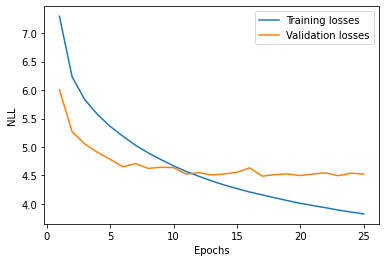

In [ ]:

# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | not to be a few of the two other than
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | States for a <unk> of the <unk> in the <unk>
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single @-@ not the Republic of the network @-@ out
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and <unk> . <eol> In the <unk> of the <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ <unk> . This , and the two other <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | <unk> of the two other than the <unk> in the
Input | Output #6: <unk> , $ 96 